# Authentication Demonstration

In this notebook, the satellite based navigation message authentication provided by Galileo OSNMA and QZSS QZNMA will be demonstrated.

Please note that the public key information need to be prepared by user. 

For Galileo OSNMA, `OSNMA_MerkleTree*.xml` should be downloaded from [EUSPA web site](https://www.gsc-europa.eu/) (registration is required), and copied to `../data/pubkey/onsma/`.

For QZSS QZNMA, the public Keys are distributed directly by Signal Authentication System Operator upon receiving the [requests](https://qzss.go.jp/en/inquiry/) to the [MICHIBIKI website](https://qzss.go.jp/en/) of Cabinet Office. Please copy the public keys `*.der` to `../data/pubkey/qznma/`.




In [3]:
%cd cssrlib-data/samples

c:\work\gps\cssrlib\tutorials\cssrlib-data\samples


## Example 1: Galileo OSNMA Demonstration 

In [4]:
import os
import numpy as np
import cssrlib.osnma as om
from sys import exit as sys_exit
from binascii import unhexlify, hexlify
import matplotlib.pyplot as plt

In [19]:
tofst = -2  # time offset to synchronize tow
mt_file = 'OSNMA_MerkleTree_20240115100000_newPKID_1.xml' # update if necessary

if not os.path.exists('../data/pubkey/osnma/'+mt_file):
    print('please install OSNMA_MerkleTree*.xml from EUSPA.')
    sys_exit(0)

nma = om.osnma(mt_file)

nma.flg_slowmac = False

In [8]:
year = 2025
doy = 233
session = 'h'

file_galinav = f'../data/doy{year}-{doy:03d}/{doy:03d}{session}_galinav.txt'

dtype_ = [('tow', 'i8'), ('wn', 'i8'), ('prn', 'i8'),
          ('mt', 'i8'), ('k', 'i8'), ('nma', 'S10'),
          ('wt', 'i8'), ('nav', 'S32')]

dtype_ = [('wn', 'int'), ('tow', 'float'), ('prn', 'int'),
          ('type', 'int'), ('len', 'int'), ('nav', 'S512')]

v = np.genfromtxt(file_galinav, dtype=dtype_)

In [9]:
i = 0

v = v[v['type'] == 0]  # E1 only
tow = np.unique(v['tow'])
ntow = len(tow)
nsat = np.zeros((ntow, 3), dtype=int)
vstatus = np.zeros(ntow, dtype=int)

# nep = 90
# nep = 180
nep = 300
nep = 1799

for i, t in enumerate(tow[0:nep]):
    vi = v[v['tow'] == t]
    for vn in vi:
        tow_ = int(vn['tow'])+tofst
        prn = int(vn['prn'])
        nma.prn_a = prn
        msg = unhexlify(vn['nav'])  # I/NAV (120bit+120bit)
        nav, nma_b = nma.load_gal_inav(msg)
        nma.save_gal_inav(nav, prn, tow_)
        if nma_b[0] != 0:  # for connected satellite
            nma.decode(nma_b, int(vn['wn']), tow_, prn)
            nsat[i, 1] += 1

    nsat[i, 0] = len(vi)
    nsat[i, 2] = nma.nsat  # authenticated sat
    vstatus[i] = nma.status

decode_hk succeeded 2380/370919 prn=21 gst_tow=370890 did=5
root-key verified 2380/370919 prn=21 gst_tow=370890
Key chain verified     2380/370919 prn=21 gst_tow=370890
MAC Look-up Table verified on 2380/370919 prn=21 gst_tow=370860
MACSEQ Verified on 2380/370919 prn=21
# 1 prn_d=21 adkd= 0 iodnav=108 tag verified
# 2 prn_d=29 adkd= 0 iodnav=106 tag verified
# 3 prn_d=21 adkd= 4 tag verified
# 4 prn_d=23 adkd= 0 iodnav=103 tag verified
5 prn_d=21 adkd=12 slow-MAC is skipped
# 6 prn_d=27 adkd= 0 iodnav=104 tag verified
MAC Look-up Table verified on 2380/370919 prn=10 gst_tow=370860
MACSEQ Verified on 2380/370919 prn=10
# 1 prn_d=10 adkd= 0 iodnav=108 tag verified
# 2 prn_d=12 adkd= 0 iodnav=108 tag verified
# 3 prn_d=10 adkd= 4 tag verified
# 4 prn_d=11 adkd= 0 iodnav=106 tag verified
5 prn_d=10 adkd=12 slow-MAC is skipped
6 prn_d=9 adkd=0 navmsg is not available.
MAC Look-up Table verified on 2380/370919 prn=33 gst_tow=370860
MACSEQ Verified on 2380/370919 prn=33
# 1 prn_d=33 adkd= 0 i

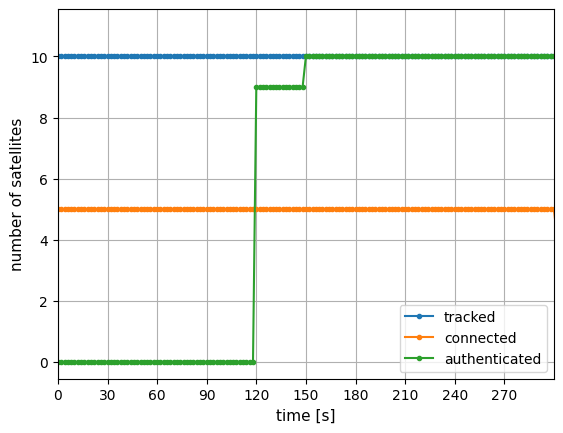

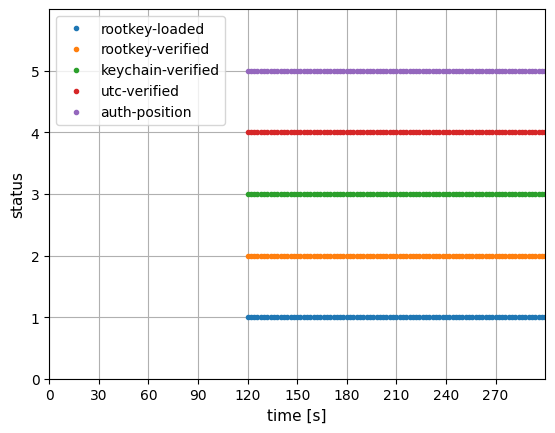

In [10]:
if True:
    fsz = 11
    tmax = 300

    fig, ax = plt.subplots()
    plt.plot(tow-tow[0], nsat[:, 0], '.-', label='tracked')
    plt.plot(tow-tow[0], nsat[:, 1], '.-', label='connected')
    plt.plot(tow-tow[0], nsat[:, 2], '.-', label='authenticated')
    plt.grid()
    plt.legend()
    plt.xlim([0, tmax])
    ax.set_xticks(np.arange(0, 300, 30))
    plt.ylabel('number of satellites', fontsize=fsz)
    plt.xlabel('time [s]', fontsize=fsz)
    plt.savefig('osnma-{0:d}-nsat-{1:d}.png'.format(doy, tmax))
    plt.show()

    y = np.ones(ntow)
    lbl_t = ['rootkey-loaded', 'rootkey-verified', 'keychain-verified',
             'utc-verified', 'auth-position']
    fig, ax = plt.subplots()
    for k in range(5):
        idx = np.where(vstatus & (1 << k))
        plt.plot(tow[idx]-tow[0], y[idx]*(k+1), '.', label=lbl_t[k])
    plt.grid()
    ax.set_yticks(np.arange(0, 6))
    ax.set_xticks(np.arange(0, 300, 30))
    plt.legend()
    plt.ylim([0, 6])
    plt.xlim([0, tmax])
    plt.ylabel('status', fontsize=fsz)
    plt.xlabel('time [s]', fontsize=fsz)
    plt.savefig('osnma-{0:d}-status.png'.format(doy))
    plt.show()


## Example 2: QZSS QZNMA Demonstration


In [11]:
import os
from sys import exit as sys_exit
from binascii import unhexlify
import numpy as np
from cssrlib.gnss import prn2sat, uGNSS
from cssrlib.qznma import qznma, uNavId
import matplotlib.pyplot as plt

In [12]:
if not os.path.exists('../data/pubkey/qznma/002.der'):
    print('please install public key file from QSS.')
    sys_exit(0)


In [15]:
dtype = [('wn', 'int'), ('tow', 'float'), ('prn', 'int'),
         ('type', 'int'), ('len', 'int'), ('nav', 'S512')]
msg_nav_t = {uNavId.GPS_LNAV: 'LNAV', uNavId.GPS_CNAV: 'CNAV',
             uNavId.GPS_CNAV2: 'CNAV2',
             uNavId.GAL_FNAV: 'F/NAV', uNavId.GAL_INAV: 'I/NAV'}

# prn_ref = -1
prn_ref = 199
navmode = uNavId.GPS_LNAV  # 1:LNAV, 2:CNAV, 3:CNAV2
year = 2025
doy = 233
session = 'h'
flg_gnss = True

qz = qznma()
qz.monlevel = 1

bdir = f'../data/doy{year}-{doy:03d}/'

if navmode == uNavId.GPS_LNAV:
    navfile = bdir+f'{doy:03d}{session}_qzslnav.txt'
elif navmode == uNavId.GPS_CNAV:
    navfile = bdir+f'{doy:03d}{session}_qzscnav.txt'
elif navmode == uNavId.GPS_CNAV2:
    navfile = bdir+f'{doy:03d}{session}_qzscnav2.txt'

v = np.genfromtxt(navfile, dtype=dtype)

In [16]:
if navmode == uNavId.GPS_CNAV:
    v = v[v['type'] == 26]  # L5 CNAV only

if flg_gnss:
    navfile_n = bdir+f'{doy:03d}{session}_qzsl6.txt'
    navfile_gpslnav = bdir+f'{doy:03d}{session}_gpslnav.txt'
    navfile_gpscnav = bdir+f'{doy:03d}{session}_gpscnav.txt'
    # navfile_gpscnav2 = bdir+'{doy:03d}{session}_gpscnav2.txt'
    navfile_galinav = bdir+f'{doy:03d}{session}_galinav.txt'
    navfile_galfnav = bdir+f'{doy:03d}{session}_galfnav.txt'

    # load navigation message
    qz.load_navmsg_lnav(navfile_gpslnav)
    qz.load_navmsg_cnav(navfile_gpscnav)
    qz.load_navmsg_inav(navfile_galinav)
    qz.load_navmsg_fnav(navfile_galfnav)

    vn = np.genfromtxt(navfile_n, dtype=dtype)

In [17]:
# tow_ = np.unique(v['tow'])
tow_ = np.arange(v['tow'][0], v['tow'][-1])
nep = len(tow_)
# nep = 1200

nsat = np.zeros((nep, 4), dtype=int)
vstatus = np.zeros(nep, dtype=int)

for k in range(nep):
    vi_ = v[v['tow'] == tow_[k]]

    for vi in vi_:
        msg = unhexlify(vi['nav'])
        sat = prn2sat(uGNSS.QZS, vi['prn'])
        qz.decode(tow_[k], msg, None, sat, navmode)

    if flg_gnss:
        vin_ = vn[(vn['tow'] == tow_[k]) & (vn['type'] == 1)]
        if prn_ref > 0:
            vin_ = vin_[vin_['prn'] == prn_ref]

        for vin in vin_:
            msg_n = unhexlify(vin['nav'])
            qz.decode(tow_[k], None, msg_n, sat, navmode)

    nsat[k, 0] = qz.count_tracked_sat(tow_[k])
    nsat[k, 1:] = np.array([qz.nsat[d] for d in qz.nsat])

#tow=370816 mt=1 sys=0 prn=10 signature OK.
#tow=370827 mt=1 sys=0 prn=24 signature OK.
#tow=370836 mt=1 sys=0 prn=15 signature OK.
#tow=370837 mt=1 sys=0 prn=25 signature OK.
#tow=370846 mt=1 sys=0 prn=32 signature OK.
#tow=370857 mt=1 sys=0 prn=23 signature OK.
#tow=370866 mt=1 sys=0 prn=12 signature OK.
#tow=370866 mt=1 sys=0 prn=18 signature OK.
#tow=370867 mt=5 sys=1 prn= 4 signature OK.
#tow=370877 mt=5 sys=1 prn=11 signature OK.
#tow=370886 mt=5 sys=1 prn=21 signature OK.
#tow=370897 mt=5 sys=1 prn=33 signature OK.
#tow=370897 mt=5 sys=1 prn=27 signature OK.
#tow=370906 mt=5 sys=1 prn=19 signature OK.
#tow=370906 mt=2 sys=0 prn=10 signature OK.
#tow=370916 mt=5 sys=1 prn=12 signature OK.
#tow=370916 mt=2 sys=0 prn=25 signature OK.
#tow=370917 mt=2 sys=0 prn=32 signature OK.
#tow=370936 mt=2 sys=0 prn=23 signature OK.
#tow=370946 mt=2 sys=0 prn=18 signature OK.
#tow=370947 mt=2 sys=0 prn=24 signature OK.
#tow=370967 mt=4 sys=1 prn=11 signature OK.
#tow=370976 mt=4 sys=1 prn=12 si

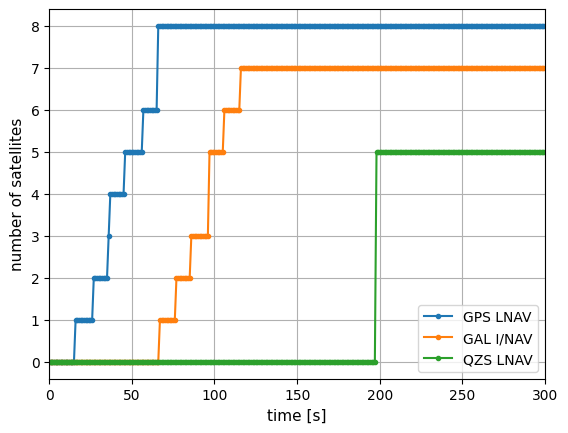

In [18]:
if True:
    fsz = 11

    tmax = 300
    t = tow_-tow_[0]

    fig, ax = plt.subplots()
    # plt.plot(tow_-tow_[0], nsat[:, 0], label='tracked')
    plt.plot(t, nsat[:, 1], '.-', label='GPS ' +
             msg_nav_t[qz.navmode[uGNSS.GPS]])
    plt.plot(t, nsat[:, 2], '.-', label='GAL ' +
             msg_nav_t[qz.navmode[uGNSS.GAL]])
    plt.plot(t, nsat[:, 3], '.-', label='QZS '+msg_nav_t[navmode])
    plt.grid()
    plt.legend()
    plt.xlim([0, tmax])
    # ax.set_xticks(np.arange(0, 300, 30))
    plt.ylabel('number of satellites', fontsize=fsz)
    plt.xlabel('time [s]', fontsize=fsz)
    plt.savefig('qznma-{0:d}-nsat-{1:d}.png'.format(doy, tmax))
    plt.show()

## Reference

[^1] Galileo Open Service Navigation Message Authentication (OSNMA)
    Signal-in-Space Interface Control Document (SIS ICD), October, 2023.

[^2] Galileo Open Service Navigation Message Authentication (OSNMA)
    Receiver Guidelines Issue 1.3, January, 2024.

[^3] Quasi-Zenith Satellite System Interface Specification
    Signal Authentication Service (IS-QZSS-SAS-001),
    March, 2024